In [2]:
import os
import sys
from dotenv import load_dotenv, find_dotenv
sys.path.append(os.path.abspath('..'))
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)
import modin.pandas as pd
#import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from src.features.build_features import textProcessor
from src.code_snippets.visualization.bars import add_top_bar_labels


from src.code_snippets.dataprep.embeddings_preprocessing.glove.twitter_preprocessing import preprocessing
from src.code_snippets.dataprep.cleaner import (count_characters_in_tokenized_sentence,
                                                count_punctuations_in_tokenized_sentece,
                                                count_ner_tags_in_tokenized_sentence,remove_stopwords)

from src.code_snippets.dataprep.embeddings_preprocessing.glove.reader import read_glove_file
import modin.pandas as pd
import multiprocessing as mp
from nltk.parse.corenlp import CoreNLPParser
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.tag import pos_tag
import re

In [3]:
df = pd.read_csv('../data/raw/train.csv')

In [4]:
len(df)

159571

We have almost 160K comments.

In [5]:
#remove \n
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub("\\n"," ",x))

#Tokenize
df['comment_tokenized'] = df['comment_text'].apply(lambda x: word_tokenize(x))

#Get length of comment
df['num_words'] = df['comment_tokenized'].apply(lambda x: len(x))

#Get a clean column
df['clean'] = (df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1)==0)*1


In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_tokenized,num_words,clean
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,"[Explanation, Why, the, edits, made, under, my...",49,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[D'aww, !, He, matches, this, background, colo...",27,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[Hey, man, ,, I, 'm, really, not, trying, to, ...",48,1
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0,"[``, More, I, ca, n't, make, any, real, sugges...",128,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[You, ,, sir, ,, are, my, hero, ., Any, chance...",18,1


In [6]:
#Remove stop words
df['comment_tokenized'] = df['comment_tokenized'].apply(lambda x: remove_stopwords(x))


In [7]:
labels_df = df[['toxic','severe_toxic','obscene','threat','insult','identity_hate','clean']]

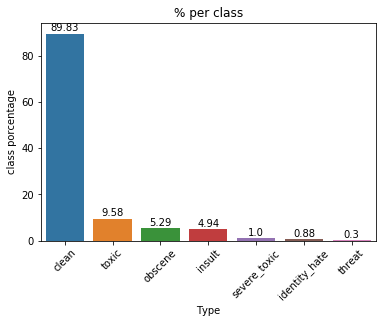

In [8]:
labels_df_pct = (labels_df.sum()*100/len(df)).round(2)
labels_df_pct = labels_df_pct.sort_values(ascending=False)
ax = sns.barplot(x=labels_df_pct.index,y=labels_df_pct.values,order =labels_df_pct.index)
ax.set(title = "% per class" ,ylabel = 'class porcentage' , xlabel = 'Type')
plt.xticks(rotation=45)
#adding the text labels
add_top_bar_labels(ax,labels_df_pct.values)
plt.show()

Lets see how many comments have more than one tag. We are not including clean tags here because this can only have one tag. i.e. a comment can't be both clean and toxic

To request implementation, send an email to feature_requests@modin.org.


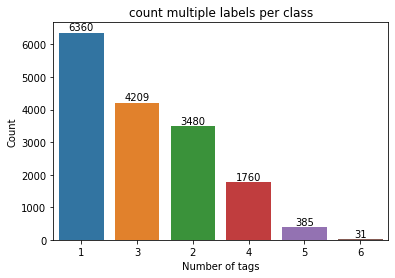

In [9]:
num_tags =  labels_df.drop('clean',axis=1).sum(axis=1).value_counts()
num_tags.drop(0,axis=0,inplace=True)
num_tags = num_tags.sort_values(ascending=False)

ax = sns.barplot(x=num_tags.index,y=num_tags.values,order=num_tags.index)
ax.set(title = "count multiple labels per class" ,ylabel = 'Count' , xlabel = 'Number of tags')

#adding the text labels
add_top_bar_labels(ax,num_tags.values)
plt.show()

So aside from the clean comments, one tag seems to be the most common, followed by three tags

I want to see which 2 tags appear together most often. Also, it could be interesting to see the top group of three, of four, and so on

In [10]:
num_tags_sum_df = labels_df.drop('clean',axis=1).sum(axis=1)
mask = labels_df.clean==0
groups_count = labels_df[mask].\
                    drop('clean',axis=1).\
                    apply(lambda x:
                    [list(x.index[x==1]),len(x.index[x==1])],axis=1)

groups_count = pd.DataFrame(groups_count.tolist(),columns=['groups','count'])
groups_count['groups'] = groups_count.groups.astype(str)

Top singles

In [11]:
groups_count.loc[groups_count['count']==1,'groups'].value_counts()

['toxic']            5666
['obscene']           317
['insult']            301
['identity_hate']      54
['threat']             22
dtype: int64

Toxic is by far the most common single tag. Notice that severe_toxic doesn't appear. This means that this tag never appears by itself! When it appears, it will almost certainly be accompanied by another label

Lets now see the top pairs

In [12]:
groups_count.loc[groups_count['count']==2,'groups'].value_counts()

['toxic', 'obscene']            1758
['toxic', 'insult']             1215
['obscene', 'insult']            181
['toxic', 'identity_hate']       136
['toxic', 'threat']              113
['toxic', 'severe_toxic']         41
['insult', 'identity_hate']       28
['obscene', 'identity_hate']       3
['threat', 'insult']               3
['obscene', 'threat']              2
dtype: int64

Toxic and obscene is the most frequent pair. Just next is toxic and insult. 
This makes me wonder, of all the times obscene appear, what percentage is in one of these pairs?

In [13]:
groups_count.loc[groups_count['count']==2,'groups'].value_counts()[0]*100/labels_df['obscene'].sum()

20.807196117883773

20% its a lot, but obscene as a single is much less than 20% (only 317 comments). brings me to think that there is a famous triplet with obscene in it.

In [14]:
groups_count.loc[groups_count['count']==3,'groups'].value_counts()



['toxic', 'obscene', 'insult']                3800
['toxic', 'severe_toxic', 'obscene']           158
['toxic', 'insult', 'identity_hate']           134
['toxic', 'obscene', 'identity_hate']           35
['obscene', 'insult', 'identity_hate']          18
['toxic', 'threat', 'insult']                   16
['toxic', 'severe_toxic', 'insult']             14
['toxic', 'obscene', 'threat']                  11
['toxic', 'severe_toxic', 'threat']             11
['toxic', 'threat', 'identity_hate']             7
['toxic', 'severe_toxic', 'identity_hate']       3
['obscene', 'threat', 'insult']                  2
dtype: int64

It is! toxic, obscene and insult seem to be very common. 

In [15]:
groups_count.loc[groups_count['count']==3,'groups'].value_counts()[0]*100/labels_df['obscene'].sum()



44.975736773582675

This is a very high percentage. Also notice that the behavior of "obscene" is very similar to "insult". both obscene and insult most common pair is with toxic. Also, the most common triplet is obscene,insult and toxic. In fact, comments that are tagged with ["toxic","obscene","insult"] or ["toxic","obscene"] cover up to 65% of the comments tagged with "obscene".

A simmilar things happens with insult. Comments that are tagged with ["toxic","obscene","insult"] or ["toxic","insult"] cover almost 70%. 

This make me consider a hierarchical model. First a model that classifies between insult, clean and other. These probabilities could be the input of another model that classifies that obscene, identity_hate, severe_toxic and threat. It's just a thought that might be worth exploring.

To finalize with this overlapping sets analysis, lets just se overall value counts of groups.
Lets see if pareto principle applies for the not clean labels. Are there a small set of tag groups that conform most of the not clean comments? Lets plot the cumulative percentage of counts.

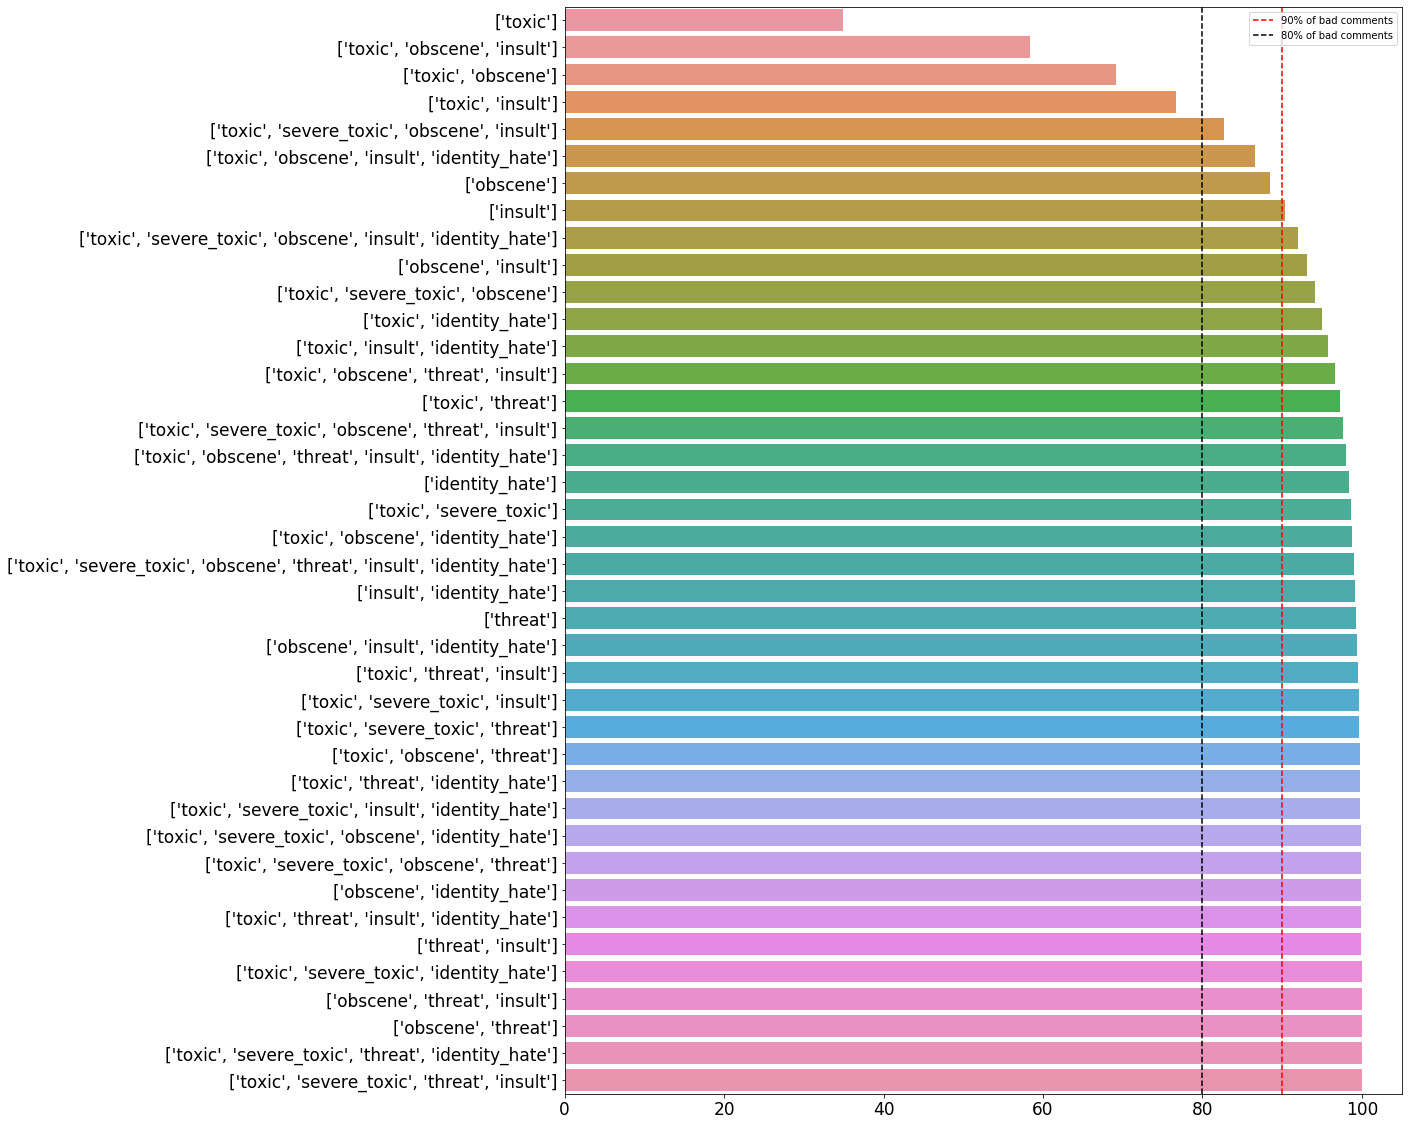

In [16]:
v_counts = groups_count['groups'].value_counts()
cumsum_pct = v_counts.cumsum()*100/v_counts.sum()
plt.figure(figsize = (15,20))
ax = sns.barplot(x=cumsum_pct.values,y=cumsum_pct.index,orient='h')
plt.yticks(fontsize = 17)
plt.xticks(fontsize = 17)
plt.axvline(90,c='red',linestyle='--',label = '90% of bad comments')
plt.axvline(80,c='black',linestyle='--', label= '80% of bad comments')
plt.legend()
plt.show()

WOW, this is pareto on steroids. 20% of the groups would be 8 groups. If we select the top 8 groups we already cover 90% of all comments

## Feature engineering

Lets determine the percentage of upper and lower case words in the comments

In [17]:
df['uppercase_pct'] = df['comment_tokenized'].apply(lambda x: len([i for i in x if i.isupper()])*100/len(x) )
df['lowercase_pct'] = df['comment_tokenized'].apply(lambda x: len([i for i in x if i.islower()])*100/len(x) )


Number of characters per comment

In [18]:
df['num_characters'] = df['comment_tokenized'].apply(count_characters_in_tokenized_sentence)

Exclamation marks could bring information because it could mean like "yelling", which could mean anger.

In [19]:
df['num_exclamation'] = df['comment_tokenized'].apply(lambda x: x.count('!')+x.count('¡'))

Lets now count the rest of punctuation characters per comment (excluding exclamation mark)

In [20]:
df['num_punctuation'] = df['comment_tokenized'].apply(count_punctuations_in_tokenized_sentece)

I think that counting verbs, adjetives, nouns and pronouns could be useful. For example, if you are directing personally to another person you might use pronouns. You could also use nouns and adjetives to insult people. Let's see some examples

In [21]:
print(pos_tag('you are an idiot.'.split(),tagset='universal'))
print(pos_tag('he is incredibly stupid.'.split(),tagset='universal'))
print(pos_tag('i am going to kill you'.split(),tagset='universal'))

[('you', 'PRON'), ('are', 'VERB'), ('an', 'DET'), ('idiot.', 'NOUN')]
[('he', 'PRON'), ('is', 'VERB'), ('incredibly', 'ADV'), ('stupid.', 'ADJ')]
[('i', 'NOUN'), ('am', 'VERB'), ('going', 'VERB'), ('to', 'PRT'), ('kill', 'VERB'), ('you', 'PRON')]


In [22]:
df['num_nouns'] = df['comment_tokenized'].\
    apply(lambda x: count_ner_tags_in_tokenized_sentence(x,'NOUN'))
df['num_adjetives'] = df['comment_tokenized'].\
    apply(lambda x: count_ner_tags_in_tokenized_sentence(x,'ADJ'))
df['num_pronouns'] = df['comment_tokenized'].\
    apply(lambda x: count_ner_tags_in_tokenized_sentence(x,'PRON'))
df['num_verbs'] = df['comment_tokenized'].\
    apply(lambda x: count_ner_tags_in_tokenized_sentence(x,'VERB'))

(-5, 40)

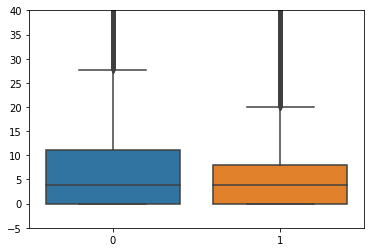

In [23]:
sns.boxplot(x=df['clean'].astype(str).values,y=df['uppercase_pct'].values)
plt.ylim(-5,40)

The box plots are simmilar, the 25th and 50th percentile are virtually the same. However, the 75th percentile and max values tend to be higher on bad comments, so this could be a good feature.

(-1, 30)

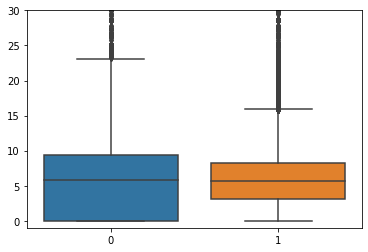

In [24]:
sns.boxplot(x=df['clean'].astype(str).values,y=(df['num_adjetives']*100/df['num_words']).values)
plt.ylim(-1,30)

Distributions do look different although both have the same median. It appears like bad comments have a larger standar deviation for this variable.

(-1, 15)

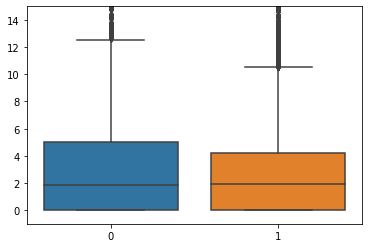

In [25]:
sns.boxplot(x=df['clean'].astype(str).values,y=(df['num_pronouns']*100/df['num_words']).values)
plt.ylim(-1,15)

(-1, 60)

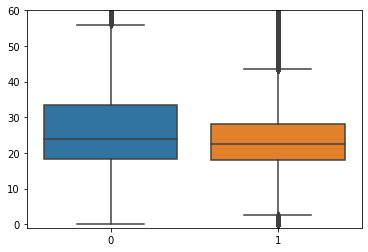

In [26]:
sns.boxplot(x=df['clean'].astype(str).values,y=(df['num_nouns']*100/df['num_words']).values)
plt.ylim(-1,60)

the 75th percentile, max value and median look a bit higher in the bad comments

(-1, 30)

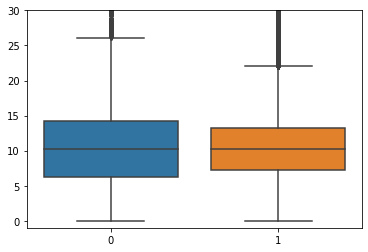

In [27]:
sns.boxplot(x=df['clean'].astype(str).values,y=(df['num_verbs']*100/df['num_words']).values)
plt.ylim(-1,30)

Here we see something similar than with the upper case percentage

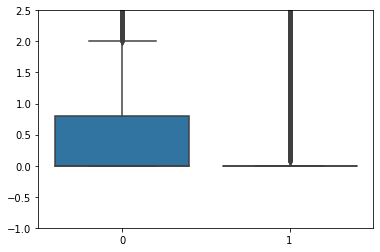

In [28]:
sns.boxplot(x=df['clean'].astype(str).values,y=(df['num_exclamation']*100/df['num_words']).values)
plt.ylim(-1,2.5)
plt.show()

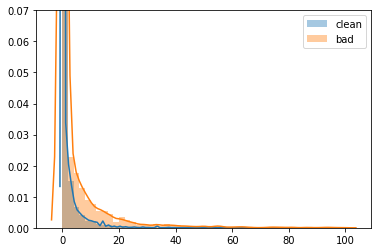

In [29]:

sns.distplot((df.loc[df['clean']==1,'num_exclamation']*100/df.loc[df['clean']==1,'num_words']).values,hist_kws={'log':False},kde = True,label='clean')

sns.distplot((df.loc[df['clean']==0,'num_exclamation']*100/df.loc[df['clean']==0,'num_words']).values,hist_kws={'log':False},kde = True,label='bad')
plt.legend()
plt.ylim(0,0.07)
plt.show()

It does look like bad comments tend to have a bit more exclamation marks than clean ones

In [30]:
(df['num_exclamation']*100/df['num_words']).groupby(df['clean']).describe()

,count,mean,std,min,25%,50%,75%,max
clean,,,,,,,,
0,16225.0,2.979791,8.902553,0.0,0.0,0.0,0.8,99.878739
1,143346.0,0.603163,3.115795,0.0,0.0,0.0,0.0,98.293515


Okay so it definitely looks that bad comments are a bit more likely of having a high percentage of exclamation marks 

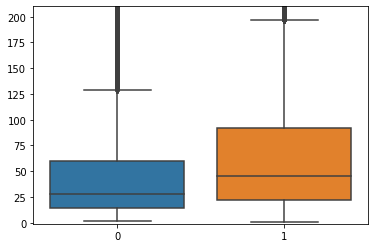

In [31]:
sns.boxplot(x=df['clean'].astype(str).values,y=(df['num_words']).values)
plt.ylim(-1,210)
plt.show()

In [32]:
df.groupby('clean')['num_words'].describe()

,count,mean,std,min,25%,50%,75%,max
clean,,,,,,,,
0,16225.0,64.649676,147.652255,2.0,14.0,28.0,60.0,4948.0
1,143346.0,82.102110,117.238210,1.0,22.0,45.0,92.0,3042.0


This is perhaps one of the strongest differences in a feature between clean and inappropriate comments. The median number of words of clean comments is 60% higher than that of bad comments. First and third quartiles are also higher for clean comments. It looks like toxic comments tend to be shorter.

## Explore GloVe

In [42]:

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
#embedding = gensim.models.KeyedVectors.load_word2vec_format(
#    '../../pretrained_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt', binary=False)

words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(
    '../../pretrained_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt')

In [8]:
examples={'animals':['cat','dog','bird','lion'],
          'colors': ['red','white','blue','black'],
          'fruits':['apple','pear','banana','grape'],
          'vegetable':['lettuce','cauliflower','onion','tomato'],
          'plants':['sunflower','bamboo','palm_tree','cactus'],
          'persons':['man','woman','child','father'],
          'automobiles':['car','truck','van','bus'],
          'other_transports':['bicycle','skateboard','roller_skates','scooter']
            }

examples_embedding = [embedding[i].reshape(1,300) for i in np.array(list(examples.values())).flatten()]
examples_embedding = np.vstack(examples_embedding)
reducer = umap.UMAP(n_neighbors=4,n_epochs=1000)
examples_umap = reducer.fit_transform(examples_embedding)

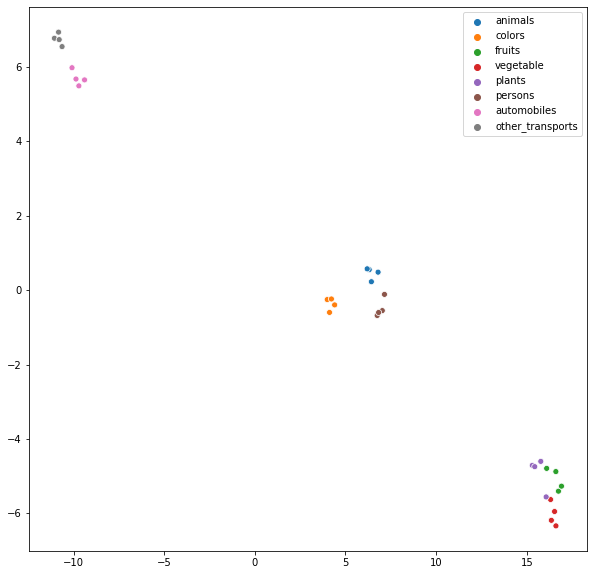

In [9]:
plt.figure(figsize = (10,10))
hue = np.repeat(list(examples.keys()),[len(i) for i in examples.values()])
sns.scatterplot(examples_umap[:,0],examples_umap[:,1],marker='o',hue = hue)
plt.show()

contractions?

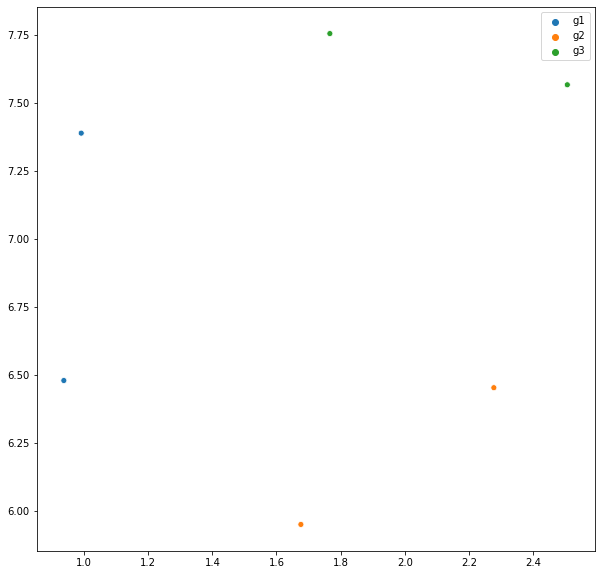

In [10]:
examples = {'g1':["can't","couldn't"],
            'g2':["weren't","wasn't"],
            'g3':["you're","you've"]}

examples_embedding = [embedding[i].reshape(1,300) for i in np.array(list(examples.values())).flatten()]
examples_embedding = np.vstack(examples_embedding)
reducer = umap.UMAP(n_neighbors=4,n_epochs=1000)
examples_umap = reducer.fit_transform(examples_embedding)

plt.figure(figsize = (10,10))
hue = np.repeat(list(examples.keys()),[len(i) for i in examples.values()])
sns.scatterplot(examples_umap[:,0],examples_umap[:,1],marker='o',hue = hue)
plt.show()